# CORD-19 Data munging

## Purpose
What we want to do here is 
- check the data for quality: missing data, errors, inconsistencies. fix issues where possible
- add other useful data like CrossRef

#### Output should be
- consistent and useful df of paragraph-length text items. 

## Usage notes
- This is very slow to run.
- You will need to add your email address to an environment variable on your machine called 'myemail' if you want to acquire crossref data.


## General notes on CORD-19 data
- not all articles represent research articles. There is front/back matter as well as book chapters etc.
- There's no 'publisher' column, so publishers can't use this to find their own content easily. Need to crossreference with CrossRef data.
- some pids, DOIs, titles and abstracts are missing from the metadata.csv. These might be useful, so see if you can replace them. 
- Full text data is quite consistent, but there is some inconsistent formatting.

In [ ]:
## Download the data
#!curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-13/comm_use_subset.tar.gz --output data/comm_use_subset.tar.gz
#!curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-13/noncomm_use_subset.tar.gz --output data/noncomm_use_subset.tar.gz 
#!curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-13/pmc_custom_license.tar.gz --output data/pmc_custom_license.tar.gz
#!curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-03-13/biorxiv_medrxiv.tar.gz --output data/biorxiv_medrxiv.tar.gz

In [2]:
%matplotlib inline
import tarfile
import json
import os
import pandas as pd
import numpy as np

## Look at the metadata.
If we are doing doc2vec/scispacy vectorisation later on, we might need titles and abstracts - or equivalent-length documents. Let's see how much of that is here.

In [3]:
meta = pd.read_csv('data/metadata.csv')
meta.shape

(44220, 15)

In [4]:
meta.head(2)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license
1,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850.0,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,custom_license


In [5]:
# count missing values
for col in meta.columns:
    print(col, meta[col].isna().sum())

sha 15758
source_x 0
title 224
doi 3470
pmcid 20901
pubmed_id 21277
license 0
abstract 8414
publish_time 10023
authors 3146
journal 11047
Microsoft Academic Paper ID 43256
WHO #Covidence 42453
has_full_text 0
full_text_file 11391


- Quite a lot of abstracts are missing, so it might be worth seeing if we can get equivalent text data from the full-text files. 
- Note that missing abstracts appear as 'nan' AND as 'Unknown'
- Just a few missing titles. 
- DOIs appear to be the identifier with the best coverage.

## Curious issue
Pubmed seems to put a full-stop at the end of it's titles. This is an odd thing to do and it can mess up some text-modelling if we include punctuation (BERT and Google AutoML will both suffer if we leave this in)

In [6]:
sum([(str(x)[-1]=='.') for x in meta['title']])

1540

Indeed, there are some titles ending in '.'. Remove these.

In [7]:
meta['title'] = [str(x)[:-1] if (str(x)[-1]=='.') else str(x) for x in meta['title']]

# take a look at the text data - other than missing abstracts, are there any odd articles?
- should probably drop non-English literature.
- also drop anything that is odd, like front/back matter, editorials, corrigenda, book chapters...

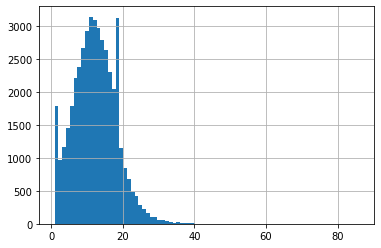

In [8]:
pd.Series([len(x.split()) for x in meta['title']]).hist(bins = 80)

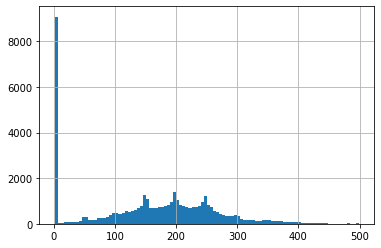

In [9]:
pd.Series([len(str(x).split()) for x in meta['abstract'] if len(str(x).split())<500]).hist(bins = 100)

- limited the x-axis because some abstracts are absurdly long.
- Odd little peaks at 150, 200, 250 words. Guessing that these are word-limits imposed by journals on abstract length?

Check absurdly long abstracts

In [10]:
# edit the length restriction below to see artilces with long abstracts
meta[[True if len(str(x).split())>500 else False for x in meta['abstract'].values]].shape

(134, 15)

In [11]:
# drop rows with long abstracts
# switch the '>' in the above to a '<'  !!!
meta = meta[[True if len(str(x).split())<500 else False for x in meta['abstract'].values]]
meta.shape

(44083, 15)

## Duplication of titles?

In [12]:
from collections import Counter
meta['title'].value_counts(ascending = False)[:30]

Index                                                                       348
nan                                                                         224
Subject Index                                                                83
Subject index                                                                76
Author index                                                                 69
Contents                                                                     68
Articles of Significant Interest Selected from This Issue by the Editors     67
Information for Authors                                                      66
Graphical contents list                                                      36
Table of Contents                                                            29
Infectious disease surveillance update                                       24
In brief                                                                     21
Preface                                 

- there are a huge number of articles in the data which are not going to be research articles. We can drop these now and potentially reduce noise in the dataset. It might also be worth dropping titles including certain words, like 'editorial', 'contents', 'index', but some of these words might come up in other contexts...

In [13]:
# what are we left with if we simply drop all duplicates?
meta.drop_duplicates('title', keep = False).shape

(41619, 15)

In [14]:
# manually check some of these - are any worth keeping?
# meta[meta['title']=='PNAS Plus Significance Statements']
# meta[meta['title']=='nan'].source_x.value_counts()
# meta[meta['title']=='nan']['abstract'].unique()

Dropping duplicate titles seems worthwhile since it reduces the content that we don't want. However, it's not going to get rid of all the non-research articles with unique titles and there's no simple way to deal with them.

Also, there are 224 articles with 'nan' as a title. From a manual check, there's nothing to indicate these are worth keeping, but it's not very clear. For the sake of time, lets drop them.

In [15]:
# drop nans and duplicates
meta = meta.drop_duplicates('title', keep = False)
meta.shape

(41619, 15)

In [16]:
meta['tiabs'] = meta['title'] + '. ' +meta['abstract']

In [17]:
# drop appendices - these aren't research articles either
meta = meta[[str(x).lower()[:8]!='appendix' for x in meta['tiabs']]]
meta.shape

(41595, 16)

# Full text data
The full-text data is stored in tar files as JSON. We'll pull this out and check it and clean it before using it to update our dataframe. 

In [18]:
%%time
data = []

sets = ['data/'+x for x in os.listdir('data') if '.tar.gz' in x]

for set_ in sets:
    with tarfile.open(set_, "r:gz") as tar:
    #     print(tar.getmembers())
        for i,member in enumerate(tar.getmembers()):
            f=tar.extractfile(member)
            if f is not None:
                data.append(json.load(f)) #.read())
len(data), sets

Wall time: 52.7 s


(29315,
 ['data/biorxiv_medrxiv.tar.gz',
  'data/comm_use_subset.tar.gz',
  'data/custom_license.tar.gz',
  'data/noncomm_use_subset.tar.gz'])

#### quick consistency check
Just looking for text data at the moment. 

In [19]:
# how many have titles, how many have abstracts
counts = {}
for item in data:
    for key in item:
        if key not in counts:
            counts[key]=1
        else:
            counts[key]+=1
counts

{'paper_id': 29315,
 'metadata': 29315,
 'abstract': 29315,
 'body_text': 29315,
 'bib_entries': 29315,
 'ref_entries': 29315,
 'back_matter': 29315}

## Data checks
- look for missing daat, duplicate rows, errors etc...

In [20]:
# unique documents
len(list(set([x['paper_id'] for x in data])))

29315

In [21]:
# titles?
len(list(set([x['metadata']['title'] for x in data])))

25114

Some titles are not unique. Causes:
- missing titles
- article types as titles (like 'opinion piece')
- duplication of articles - Duplication seems like a relatively minor feature of the data. None of the other duplicated titles seem like they would create a significant problem in the text-data.

In [22]:
# which ones aren't unique
from collections import Counter
Counter([x['metadata']['title'] for x in data]).most_common(30)

[('', 3583),
 ('Original Article', 38),
 ('Comment', 29),
 ('A', 15),
 ('CLINICAL EXPERIMENTAL VACCINE RESEARCH', 14),
 ('-NC-ND license (http://creativecommons.org/licenses/by-nc-nd/4.0/)', 12),
 ('ScienceDirect', 10),
 ('Access to', 8),
 ('Morbidity and Mortality Weekly Report', 8),
 ('Bibliography of the current world literature', 7),
 ('ARTICLE IN PRESS +Model', 7),
 ('Veterinary Science pISSN 1229-845X, eISSN 1976-555X', 7),
 ('Infection & Chemotherapy', 7),
 ('PEER REVIEW HISTORY', 6),
 ('The Author(s)', 6),
 ('SUBJECT INDEX', 6),
 ('International Encyclopedia of Public Health', 6),
 ('PUBLICACIÓN OFICIAL DE LA SOCIEDAD ESPAÑOLA DE ENFERMEDADES INFECCIOSAS Y MICROBIOLOGÍA CLÍNICA',
  6),
 ('Epidemiology and Infection', 5),
 ('Supporting Information', 5),
 ('Author Index', 5),
 ('Travel Medicine and Infectious Disease xxx (xxxx) xxxx', 5),
 ('INQUIRY: The Journal of Health Care Organization, Provision, and Financing',
  5),
 ('Supplementary Figures', 4),
 ('Severe Acute Respirator

Some abstracts are missing also. It's a small number, so we can probably just ignore these...

If we want to include them, perhaps just take the first para of full-text instead?

In [23]:
# how many missing abstracts?
titles = []
abstracts = []
tiabss = []
i=0
for x in data:
    title = str(x['metadata']['title'])
    
    # deal with any titles ending in '.'
    if len(title)>3 and title[-1]=='.':
        title = title[:-1]
        
    titles.append(title)
    abstract = x['abstract']
    abs_text = ''
    if type(abstract) == list and len(abstract)>0:
        for part in abstract:
            if 'text' in part and len(abs_text)==0:
                abs_text = part['text']
            else:
                abs_text = abs_text+'. '+part['text']
    abstracts.append(abs_text)
    tiabss.append(title+'. '+abs_text)
    

len(titles), len(abstracts), len(tiabss)

(29315, 29315, 29315)

The cell below is for exploring all the articles with missing title/abstract. There are definitely some issues in the text data for some percentage of articles. 

For simplicity drop everything without a typical title + abstract.

In [24]:
# m =0
# for i,x in enumerate(tiabss): 
#     if len(x)<10:
#         print(data[i])
#         print()
#         print('------------')
#         print()
#         m+=1
#         if m>5:
#             break

In [25]:
# data[i]

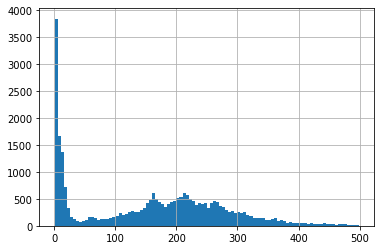

In [26]:
# what is the distribution of title+abstract lengths like?
pd.Series([len(x.split()) for x in tiabss if len(x.split())<500]).hist(bins = 100)

In [27]:
# what is 99th percentile? and 1st percentile
# perhaps drop everything outside of these ranges so that we don't have too many outliers?
pd.Series([len(x.split()) for x in tiabss]).quantile(.04),pd.Series([len(x.split()) for x in tiabss]).quantile(.99)

(1.0, 819.7200000000012)

In [28]:
len([x for x in tiabss if len(x.split())>50 and len(x.split())<500])

20018

# Add S2 API data
We can update our missing DOIs etc with data from the Semantic Scholar API.

In [29]:
%%time
# There don't seem to be proper IDs in the data (DOIs/PMIDs etc)
# let's get those from S2's API
# see docs: https://api.semanticscholar.org/
import requests
import time

retry_failures = False

api_data = []
failures = []
api_dict = dict()
filepath = 'data/s2_api_data.json'
failpath = 'data/s2_api_data_failures.json'

# read api data from file from past iterations
if os.path.exists(filepath) and os.path.exists(failpath):
    with open(filepath, 'r') as f:
        api_data = json.load(f)
        api_dict = {x['paperId']: x for x in api_data }
    with open(failpath, 'r') as f:
        failures = json.load(f)

paper_ids = [x['paper_id'] for x in data] + [str(x) for x in meta['sha'].tolist() if len(str(x))>3]
paper_ids = list(set(paper_ids))

# if we don't have any data saved to file, hit the API for it.
if retry_failures == True or len(api_data)<len(paper_ids):        
    failures = set(failures)
    paper_ids = [x for x in paper_ids if x not in api_dict]
    print('Searching for ',len(paper_ids),'paper ids')
    base_url = 'https://api.semanticscholar.org/v1/paper/'
    for i,paper_id in enumerate(paper_ids):
        url = base_url+paper_id
        resp = requests.get(url)
        
        if resp.status_code==200:
            js = resp.json()
            api_data.append(js)
        else:
            if paper_id not in failures:
                failures.add(paper_id)
        # if we get a slow response, wait a little bit before hitting again.
        resp_time = int(resp.elapsed.total_seconds())
        if resp_time>3:
            time.sleep(resp_time)
            
        # check progress...
        if i%100==0:
            print(i,'/',len(paper_ids), ' iterations done')
            
with open(filepath,'w') as f:
    json.dump(api_data,f)
with open(failpath,'w') as f:
    json.dump(list(failures),f)
    
len(api_data), len(failures)

Searching for  22793 paper ids
0 / 22793  iterations done
100 / 22793  iterations done
200 / 22793  iterations done
300 / 22793  iterations done
400 / 22793  iterations done
500 / 22793  iterations done
600 / 22793  iterations done
700 / 22793  iterations done
800 / 22793  iterations done
900 / 22793  iterations done
1000 / 22793  iterations done
1100 / 22793  iterations done
1200 / 22793  iterations done
1300 / 22793  iterations done
1400 / 22793  iterations done
1500 / 22793  iterations done
1600 / 22793  iterations done
1700 / 22793  iterations done
1800 / 22793  iterations done
1900 / 22793  iterations done
2000 / 22793  iterations done
2100 / 22793  iterations done
2200 / 22793  iterations done
2300 / 22793  iterations done
2400 / 22793  iterations done
2500 / 22793  iterations done
2600 / 22793  iterations done
2700 / 22793  iterations done
2800 / 22793  iterations done
2900 / 22793  iterations done
3000 / 22793  iterations done
3100 / 22793  iterations done
3200 / 22793  iterati

SSLError: HTTPSConnectionPool(host='api.semanticscholar.org', port=443): Max retries exceeded with url: /v1/paper/7af71557026518d0a46748ea67380ca947b11713 (Caused by SSLError(SSLError("bad handshake: SysCallError(10054, 'WSAECONNRESET')")))

1581 failures on 17/03/2020

## Exploration questions
- look at publication dates.  What rate is content coming out at now?
- which ones are SAGE papers - we should drop the paywall on them.

In [30]:
data[0]

{'paper_id': 'f056da9c64fbf00a4645ae326e8a4339d015d155',
 'metadata': {'title': 'SIANN: Strain Identification by Alignment to Near Neighbors',
  'authors': [{'first': 'Samuel',
    'middle': ['S'],
    'last': 'Minot',
    'suffix': '',
    'affiliation': {},
    'email': ''},
   {'first': 'Stephen',
    'middle': ['D'],
    'last': 'Turner',
    'suffix': '',
    'affiliation': {},
    'email': ''},
   {'first': 'Krista',
    'middle': ['L'],
    'last': 'Ternus',
    'suffix': '',
    'affiliation': {},
    'email': ''},
   {'first': 'Dana',
    'middle': ['R'],
    'last': 'Kadavy',
    'suffix': '',
    'affiliation': {},
    'email': ''}]},
 'abstract': [{'text': 'Next-generation sequencing is increasingly being used to study samples composed of mixtures of organisms, such as in clinical applications where the presence of a pathogen at very low abundance may be highly important. We present an analytical method (SIANN: Strain Identification by Alignment to Near Neighbors) specifica

In [31]:
api_data[0]

{'abstract': 'To study the genetic diversity of enterovirus G (EV-G) among Japanese pigs, metagenomics sequencing was performed on fecal samples from pigs with or without diarrhea, collected between 2014 and 2016. Fifty-nine EV-G sequences, which were >5,000 nucleotides long, were obtained. By complete VP1 sequence analysis, Japanese EV-G isolates were classified into G1 (17 strains), G2 (four strains), G3 (22 strains), G4 (two strains), G6 (two strains), G9 (six strains), G10 (five strains), and a new genotype (one strain). Remarkably, 16 G1 and one G2 strain identified in diarrheic (23.5%; four strains) or normal (76.5%; 13 strains) fecal samples possessed a papain-like cysteine protease (PL-CP) sequence, which was recently found in the USA and Belgium in the EV-G genome, at the 2C-3A junction site. This paper presents the first report of the high prevalence of viruses carrying PL-CP in the EV-G population. Furthermore, possible inter- and intragenotype recombination events were foun

In [32]:
api_data[0].keys()

dict_keys(['abstract', 'arxivId', 'authors', 'citationVelocity', 'citations', 'corpusId', 'doi', 'fieldsOfStudy', 'influentialCitationCount', 'is_open_access', 'is_publisher_licensed', 'paperId', 'references', 'title', 'topics', 'url', 'venue', 'year'])

In [33]:

len(api_dict)

11390

# Build a dataframe
Take all of that data that we pulled and build a pandas dataframe out of it. 

In [34]:
columns = ['pid','doi','title','abstract',
           'authors', 'venue','year']
rows = []
for item in data:
    
    # define a row
    row = {col_name : '' for col_name in columns} 
    
    # now fill that row with data
    row['pid'] = item['paper_id']
    if 'paper_id' in item:
        pid = item['paper_id']
    
        if pid in api_dict:
            api_item = api_dict[pid]
            for key in columns:
                if key in api_item and key!='authors':
                    row[key] = str(api_item[key])
        else:
            
            row['title'] = item['metadata']['title']
            
            abstract = item['abstract']
            abs_text = ''
            if type(abstract) == list and len(abstract)>0:
                for part in abstract:
                    if 'text' in part and len(abs_text)==0:
                        abs_text = part['text']
                    else:
                        abs_text = abs_text+'. '+part['text']
                    if len(abs_text.split())>300:
                        break
                        
            elif 'body_text' in item:
                for text_unit in item['body_text']:
                    if 'text' in text_unit:
                        if len(abs_text)==0:
                            abs_text = text_unit['text']
                        else:
                            abs_text = abs_text +'. ' + text_unit['text']
                    if len(abs_text.split())>300:
                        break
                
            row['abstract'] = abs_text
                
        if 'authors' in item['metadata']:
            row['authors'] = '; '.join([x['last']+', '+x['first'] for x in item['metadata']['authors']])
        rows.append(row)
        

In [35]:
df = pd.DataFrame(rows, columns = columns)
df.shape

(29315, 7)

In [36]:
df.sample(3)

,pid,doi,title,abstract,authors,venue,year
219,683416e300a4f4075835852558855b07c342bd72,,Glycosylation of Zika Virus Is Important in Ho...,Zika virus (ZIKV) is a global public health is...,"Kishore, Nanda; , Routhu; Lehoux, Sylvain; Rou...",,
12809,21f5b9febaf0951142a43ae9e2c0f7baae21a307,,5 Nanodiamond: Designing the Bio-Platform,All major forms of carbon at the nanoscale -fu...,"Grichko, Varvara; Shenderova, Olga",,
21580,af48bac577dd98eff0da8ae07bc098493d041554,,,From filterable agents to virus genes: The dis...,,,


At the time of writing, some items appear to be missing from the API.  Possibly this is temporary and we will see the items showing up soon.

Checks for data quality & consistency.

### how much missing data is there?

In [37]:
for column in columns:
    print(column,':', df[df[column]==''].shape[0], '/',df.shape[0])

pid : 0 / 29315
doi : 22035 / 29315
title : 3208 / 29315
abstract : 0 / 29315
authors : 3286 / 29315
venue : 22126 / 29315
year : 22035 / 29315


In [38]:
# check missing data
df[df['title']==''].sample(3)

,pid,doi,title,abstract,authors,venue,year
11286,1e4774284ddefe5c71fca61a1bc8fd3831ece584,,,It is reasonable to assume that all organisms ...,,,
25011,ff304104b0e2e1f4c8318ec119a79721fe7a4467,,,Influenza pandemics occur when an animal influ...,,,
14747,7e9f8636b121e31595249ff3d6d16250b52f6253,,,The past decade has seen a surge in the develo...,,,


In [39]:
tiabs = []
for i,row in df.iterrows():
    if len(row['title'])==0:
        tiabs.append(row['abstract'])
    else:
        tiabs.append(row['title'] + '. ' + row['abstract'])
df['tiabs'] = tiabs

In [40]:
df.to_csv('data/s2_data.csv', encoding = 'utf-8-sig', index=False)

# Add CrossRef data
There are a lot of DOIs in the data. Unfortunately, many of them are not CrossRef DOIs (either DOIs from other registrars or errors). The functions I have for retrieving DOIs are only meant for getting a list of CrossRef DOIs, so they are a little slow here. 

In [41]:
# get crossref data incase you need it
import urllib
import requests
import time
from datetime import datetime as dt


def chunks(l, n):
    '''
    converts a list into a list of lists each with max length == n
    '''
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def get_one_crossref(doi, headers, email = 'adamday1284@gmail.com'):
    url = r'http://api.crossref.org/works/{}'.format(urllib.parse.quote(doi))
    r = requests.get(url, headers = headers)
    try:
        if r.json()['status']!='failed':
            return [r.json()['message']] # output should be a list for consistency
        else:
            print('failure for doi:',doi)
            print('(skipping)')
            raise # or return None?
    except:
        print('Error in response.  Not interpretable as json?')
        print('Searched for:', doi)
        print('Trying unescaped doi')
        url = r'http://api.crossref.org/works/{}'.format(doi)
        r = requests.get(url, headers = headers)
        try:
            js = r.json()
            if r.json()['status']!='failed':
                return [r.json()['message']] # output should be a list for consistency
            else:
                print('failure for doi:',doi)
                print('(skipping)')
                return None
            print('taking a break - sleep for 10s')
            time.sleep(10)
            return None
        except Exception as e:
            print('Error: ',e)
            return None

def get_many_crossref(dois, email = ''):
    '''
    Pulls a list of CR DOIs all at once.
    Yields output json for each batch for analysis/caching.
    -- Note that batch_size==100 seems to be a limit --
    packages: urllib, requests, time
    functions: chunks
    '''

    headers = {
    'User-Agent': 'Data analysis',
    'mailto': email
    }

    # make generator of lists
    batch_size = 100
    doi_batches = chunks(dois,batch_size)
    i = 0
    for doi_batch in doi_batches:

        # make query string
        dois_s = 'doi:' + ',doi:'.join(doi_batch)
        # Crossref documentation recommends %-encoding dois
        dois_s = urllib.parse.quote(dois_s)
        # build query url
        url = r'http://api.crossref.org/works/?filter={}&rows={}'.format(dois_s, batch_size)
        # make request
        r = requests.get(url, headers = headers)

        # check response time.
        # Documentation recommends backing off if response time is too long.
        response_time = r.elapsed.total_seconds()
        print(response_time, 'seconds for last request')

        # responses are generally <1s.
        # simple rule for sleeping if responses are slow
        if response_time > 2.0:
            print('CrossRef slow to respond. Sleep for a few seconds.')
            time.sleep(int(response_time))
            print('Finished sleeping')

        data = r.json()
        i+=1

        if data['status'] != 'failed':
            records = data['message']['items']
            n_results = len(records)

            print(dt.now())
            print(i, 'requests done')

            print(batch_size, 'items requested')
            print(n_results,'items returned')
            print('---------------------------------')

            out = data['message']['items']

            if n_results < batch_size:
                dois_returned = [record['DOI'] for record in records]
                failed_dois = [doi for doi in doi_batch
                                if doi not in dois_returned]
                if len(failed_dois)>0:
                    print('Retrieving remaining DOIs one at a time')
                    for doi in failed_dois:
                        doi_result = get_one_crossref(doi=doi, headers=headers)
                        if doi_result == None:
                            pass
                        else:
                            if type(doi_result)==dict and 'message' in doi_result:
                                out.append(doi_result['message'])
                            else:
                                out=None


            yield out
        else:
            # if there's a failure, it's likely because of a typo in a doi
            # this should retrieve all other dois in the batch
            print('Failure! - invalid doi somewhere in batch?')
            print('iterating over each item in batch:')
            for doi in doi_batch:
                out = get_one_crossref(doi=doi, headers = headers)
                if out != None:
                    yield out
                else:
                    pass



# get all crossref dates
from dateutil import parser
import datetime
from dateutil.tz import tzutc

"""
The next fn is a result of CrossRef not always having an accurate publication
date.  So, we take a best-guess that the earliest date associated with the
record is probably the publication date, or the closest thing to it.
"""
from dateutil import parser
def cr_earliest_date(works_record):
    '''
    Takes a CrossRef works record and returns the earliest date associated with it.
    packages: dateutil.parser
    '''
    date_types = ['created', 'deposited', 'indexed', 'issued',
                  'published-online', 'published-print']
    dates = []
    for date_type in date_types:
        # date_types are often missing in CrossRef works records, so we're checking
        if date_type in works_record:
            date_dict = works_record[date_type]
            for thing in date_dict:
                try:
                    dates.append(parser.parse(date_dict[thing]))
                except:
                    # in case the parser fails
                    pass
        else:
            pass
    earliest = min(dates)
    return earliest

In [42]:
%%time

cr_data_path = os.path.abspath('data/cr_data.json')
cr_data = []
if os.path.exists(cr_data_path):
    with open(cr_data_path, 'r') as f:
        cr_data = json.load(f)
cr_dict = {x['DOI']:x for x in cr_data}  
print('Already got data for ', len(cr_dict), ' crossref dois.')
dois = [x for x in df['doi'].tolist() if x not in {'',None,'None'} and x not in cr_dict]
dois.extend(meta['doi'].unique().tolist())
dois = list(set([str(x) for x in list(set(dois)) if len(str(x))>5]))
for x in get_many_crossref(dois, email = os.environ['myemail']):
    if type(x)==list:
        cr_data.extend(x)
        
with open(cr_data_path,'w') as f:
    json.dump(cr_data,f)
cr_dict = {x['DOI']:x for x in cr_data}  
len(cr_data), len(cr_dict)

Already got data for  5771  crossref dois.
32.690138 seconds for last request
CrossRef slow to respond. Sleep for a few seconds.
Finished sleeping
2020-03-25 16:37:53.553828
1 requests done
100 items requested
99 items returned
---------------------------------
Retrieving remaining DOIs one at a time
Error in response.  Not interpretable as json?
Searched for: 10.1016/B978-0-12-812735-3.00602-6
Trying unescaped doi
Error:  Expecting value: line 1 column 1 (char 0)
10.733647 seconds for last request
CrossRef slow to respond. Sleep for a few seconds.
Finished sleeping
2020-03-25 16:38:31.150073
2 requests done
100 items requested
100 items returned
---------------------------------
44.594421 seconds for last request
CrossRef slow to respond. Sleep for a few seconds.
Finished sleeping
2020-03-25 16:40:05.595943
3 requests done
100 items requested
99 items returned
---------------------------------
Retrieving remaining DOIs one at a time
Error in response.  Not interpretable as json?
Searc

(18193, 16174)

In [43]:
cr_dict = {x['DOI']:x for x in cr_data}  

In [46]:
cr_journals = []
cr_journals_short = []
cr_issns = []
publishers = []
pubdates = []
for doi in df['doi'].tolist():
    cr_journal, cr_journal_short,cr_issn, publisher, pubdate = '','','','',''
    
    if doi in cr_dict:
        item = cr_dict[doi]
    
        if 'ISSN' in item:
            cr_issn = '; '.join(item['ISSN'])
    
        pubdate = str(cr_earliest_date(item))[:10]
        
        if 'publisher' in item:
            publisher = item['publisher']
            
        if 'container-title' in item:
            cr_journal = item['container-title'][0]
            
        if 'short-container-title' in item:
            if type(item['short-container-title'])==list and len(item['short-container-title'])>0:
                cr_journal_short = item['short-container-title'][0]
            elif type(item['short-container-title'])==str:
                cr_journal_short = item['short-container-title']
        
    else:
        pass
    
    cr_journals.append(cr_journal)
    cr_journals_short.append(cr_journal_short)
    cr_issns.append(cr_issn)
    publishers.append(publisher)
    pubdates.append(pubdate)

In [47]:
df['journal'] = cr_journals
df['journal-short'] = cr_journals_short
df['pubdate'] = pubdates
df['issns'] = cr_issns
df['publisher'] = publishers

df.shape


(29315, 13)

In [48]:
df.sample(10)

,pid,doi,title,abstract,authors,venue,year,tiabs,journal,journal-short,pubdate,issns,publisher
20851,e24e2751cb0fe51505be1fee6af0a96fd42880cb,,Investigation of health care waste management ...,"In China, national regulations and standards f...","Ruoyan, Gai; Lingzhong, Xu; Huijuan, Li; Cheng...",,,Investigation of health care waste management ...,,,,,
3311,e0a2b2bc691434ef31983736806d4e558b222c92,,The Regulation of Autophagy by Influenza A Virus,Influenza A virus is a dreadful pathogen of an...,"Zhang, Rong; Chi, Xiaojuan; Wang, Song; Qi, Ba...",,,The Regulation of Autophagy by Influenza A Vir...,,,,,
27481,e8d81153777e9f92cbc2bc9ea03ed1f0d0b78543,10.1292/jvms.14-0012,"Group B Betacoronavirus in Rhinolophid Bats, J...",We report group B Betacoronavirus infection in...,"Suzuki, Jin; Sato, Ryota; Kobayashi, Tomoya; A...",The Journal of veterinary medical science,2014,"Group B Betacoronavirus in Rhinolophid Bats, J...",Journal of Veterinary Medical Science,J. Vet. Med. Sci.,2014-05-26,0916-7250; 1347-7439,Japanese Society of Veterinary Science
13985,b2a21b2d857c7babb5061f2188d93beddcc3281f,,ARTICLE IN PRESS +Model Community-acquired pne...,Objective: To provide cutting-edge information...,"Nascimento-Carvalho, Cristiana",,,ARTICLE IN PRESS +Model Community-acquired pne...,,,,,
22587,9f795a4873e2ac272c20deb2d9d5ce8ab822f9fc,,Diagnostics-in-a-Suitcase: Development of a po...,"Background: In developing countries, equipment...","Abd, Ahmed; Wahed, El; Weidmann, Manfred; Hufe...",,,Diagnostics-in-a-Suitcase: Development of a po...,,,,,
10600,108b21f42ad14d216145d1022806c138a964abd5,,"50) 29 Ariza Botero, F., see HGfner, M.C. (50)","Barlough, J., East, N., Rowe, J.D., Van Hoosea...","Author Index Allende, H; See Jardi, R; Anderso...",,,"50) 29 Ariza Botero, F., see HGfner, M.C. (50)...",,,,,
10408,8b5d7239eda302119e3960036226ce80c6a567cf,,BHV1 INFECTIONS: RELEVANCE AND SPREAD IN EUROPE,Infections caused by BHV1 are very common in E...,"Christian, Otto; Bfav, Straub",,,BHV1 INFECTIONS: RELEVANCE AND SPREAD IN EUROP...,,,,,
27738,85dfb59af4c4ec824f1f62c645e5b91a6e3cc814,,SMALL ANIMAL -CARDIOLOGY **,"Down-regulated gene expression, encoding sarco...",,,,SMALL ANIMAL -CARDIOLOGY **. Down-regulated ge...,,,,,
17682,c49347564529337e36c07817913197bc8c25b4b2,,,Summar y of the World Small Animal Veterinar y...,,,,Summar y of the World Small Animal Veterinar y...,,,,,
27694,622504276a8cd63e834d19f7b3c26ca4c2bbcb40,10.1002/glia.22880,Interleukin‐10 is a critical regulator of whit...,Neurotropic coronavirus induces an acute encep...,"Puntambekar, Shweta; Hinton, David; Yin, Xingh...",Glia,2015,Interleukin‐10 is a critical regulator of whit...,Glia,Glia,2015-06-30,0894-1491,Wiley


In [49]:
# df[[('SAGE' in x) for x in df['publisher']]].to_excel('output/SAGE_in_s2.xlsx')

In [50]:
df['publisher'].value_counts()

                                             23599
Springer Science and Business Media LLC       1525
Public Library of Science (PLoS)              1398
MDPI AG                                        665
Frontiers Media SA                             504
                                             ...  
Acta Naturae Ltd                                 1
Microbiology Society                             1
Ubiquity Press, Ltd.                             1
The American Association of Immunologists        1
Korean Academy of Rehabilitation Medicine        1
Name: publisher, Length: 151, dtype: int64

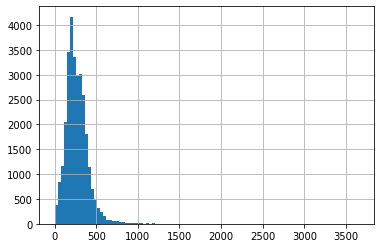

In [51]:
pd.Series([len(x.split()) for x in df['tiabs']]).hist(bins=100)

In [52]:
# drop outliers
df = df[[((len(x.split())>50) and (len(x.split())<800)) for x in df['tiabs']]]

In [53]:
df.to_csv('data/s2_cr_data.csv',index=False, encoding = 'utf-8-sig')

# merge

In [54]:
meta.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,tiabs
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license,Intrauterine virus infections and congenital h...
1,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850.0,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,custom_license,NaN
2,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701.0,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,custom_license,NaN
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077.0,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,custom_license,Clinical and immunologic studies in identical ...
4,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285.0,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,custom_license,Epidemiology of community-acquired respiratory...


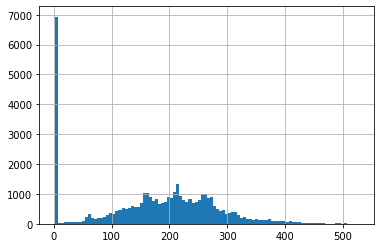

In [109]:
pd.Series([len(str(x).split()) for x in meta['tiabs'].tolist()]).hist(bins = 100)

In [75]:
# how many unique values in our identifiers?
meta_pids = meta['sha'].unique()#.values
meta_dois = meta['doi'].unique()#.values
df_dois = df['doi'].unique()#.values
df_pids = df['pid'].unique()#.values
len(meta_dois), len(meta_pids), len(df_dois), len(df_pids)

(38379, 27602, 6979, 27391)

# inspect the differences
What data is in one dataframe and not the other?

In [57]:
# which dois are in metadata and not in the full text data?
len(list(set([doi for doi in meta_dois if doi not in set(df_dois)])))

31603

In [58]:
len(list(set([doi for doi in df_dois if doi not in set(meta_dois)])))

203

In [60]:
len(list(set([pid for pid in df_pids if doi not in set(meta_pids)])))

27391

In [61]:
len(list(set([pid for pid in meta_pids if doi not in set(df_pids)])))

27602

This is annoying. If we want to ensure that we have filled in those missing abstracts, we'll basically need to iterate over the dataframes and update as we go. I can't see an easy merge operation or vector ops that will make this easy. This is going to be slow.

In [62]:
%%time
for i,row in meta.iterrows():
    pid = row['sha']
    
    # if there's no pid, then we should use doi as the id.
    if len(str(pid))<10:
        doi = row['doi']
        
        if doi in set(df['doi'].tolist()) and len(str(doi))>5:
            df_row = df[df['doi']==doi]
            
            # update the pid if possible
            row['sha'] = df_row['pid']
            if str(row['title'])=='nan':
                row['title'] = df_row['title']
            if str(row['abstract']) in {'nan','Unknown'}:
                row['abstract'] = df_row['abstract']
        else: # no pid and no doi match, so skip
            continue
            
    else: # if there IS a pid
        if pid in set(df['pid'].tolist()): # then check if that pid matches the other dataframe
            df_row = df[df['pid']==pid]
            if len(str(row['doi']))<5 and len(str(df_row['doi']))>5:
                row['doi'] = df_row['doi']
            if len(str(row['title']))<len(str(df_row['title'])) or str(row['title'])=='nan':
                row['title'] = df_row['title']
            if str(row['abstract']) in {'nan','Unknown'}:
                row['abstract'] = df_row['abstract']
                
        else: # the pid doesn't match, so check for a doi match
            doi = row['doi']
            if doi in set(df['doi'].tolist()) and len(str(doi))>5:
                df_row = df[df['doi']==doi]
                if len(str(row['doi']))<5 and len(str(df_row['doi']))>5:
                    row['doi'] = df_row['doi']
                if len(str(row['title']))<len(str(df_row['title'])) or str(row['title'])=='nan':
                    row['title'] = df_row['title']
                if str(row['abstract']) in {'nan','Unknown'}:
                    row['abstract'] = df_row['abstract']
                
            else: # no pid and no doi match, so skip
                continue
                
      # this section shows that we are mostly replacing nans          
#     if len(str(df_row['tiabs']))>len(str(row['tiabs'])) and str(row['tiabs'])!='nan':
#         print(df_row['tiabs'], row['tiabs'])
#         print()
#     if i>1000:
#         break

In [63]:
meta['doi'].isna().sum()

3217

In [64]:
meta['sha'].isna().sum()

13984

This is not a huge improvement on where we started.  It's debatable whether it's worth trying to pull text data from the full-text files like this.

## Add crossref data to metadata

In [70]:
cr_journals = []
cr_journals_short = []
cr_issns = []
publishers = []
pubdates = []
for doi in meta['doi'].tolist():
    
    cr_journal, cr_journal_short,cr_issn, publisher, pubdate = '','','','',''
    
    if doi in cr_dict:
        item = cr_dict[doi]
    
        if 'ISSN' in item:
            cr_issn = '; '.join(item['ISSN'])
    
        pubdate = str(cr_earliest_date(item))[:10]
        
        if 'publisher' in item:
            publisher = item['publisher']
            
        if 'container-title' in item:
            if type(item['container-title'])==list and len(item['container-title'])>0:
                cr_journal = item['container-title'][0]
            elif type(item['container-title'])==str:
                cr_journal = item['container-title']
                
        if 'short-container-title' in item:
            if type(item['short-container-title'])==list and len(item['short-container-title'])>0:
                cr_journal_short = item['short-container-title'][0]
            elif type(item['short-container-title'])==str:
                cr_journal_short = item['short-container-title']
        
        
        
    else:
        pass
    
    cr_journals.append(cr_journal)
    cr_journals_short.append(cr_journal_short)
    cr_issns.append(cr_issn)
    publishers.append(publisher)
    pubdates.append(pubdate)

In [71]:
meta['journal'] = cr_journals
meta['journal-short'] = cr_journals_short
meta['pubdate'] = pubdates
meta['issns'] = cr_issns
meta['publisher'] = publishers

meta.shape


(41595, 20)

In [72]:
meta.sample(2)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,tiabs,journal-short,pubdate,issns,publisher
38441,NaN,PMC,Inhibition of African swine fever virus bindin...,NaN,PMC237948,NaN,unk,"The African swine fever virus protein p12, inv...",NaN,"Angulo, A; Viñuela, E; Alcamí, A",,NaN,NaN,False,NaN,Inhibition of African swine fever virus bindin...,,,,
22218,8dd45f6f44956863508e44c1e6c7338b51a7524d,PMC,Characterizing Influenza surveillance systems ...,10.1186/1471-2458-14-850,PMC4246552,25127906.0,cc-by,BACKGROUND: Infectious disease surveillance is...,2014 Aug 15,"Zhang, Ying; Arab, Ali; Cowling, Benjamin J; S...",BMC Public Health,NaN,NaN,True,comm_use_subset,Characterizing Influenza surveillance systems ...,BMC Public Health,2014-08-15,1471-2458,Springer Science and Business Media LLC


## Which ones are published by SAGE?

In [77]:
sage = meta[[('SAGE' in x) for x in meta['publisher']]]

In [78]:
sage.shape

(120, 20)

In [80]:
# any missing DOIs?
sage['doi'].isna().sum()

0

In [81]:
# if no missing DOIs, write out to file 
# sage.to_csv('data/sage_dois_from_cord19.csv')



# Munge dates

In [100]:
dates = []
for doi in meta['doi']:
    date = '0000'
    if doi in cr_dict:
        date = cr_earliest_date(cr_dict[doi])
    dates.append(date)
meta['cr_dates'] = dates

In [98]:
(meta['cr_dates']=='0000').sum()

29225

In [103]:
def getyear(row):
    year = '0000'
    dt = row['publish_time']
    s= str(dt)
    if len(s)<4: # probably null value
        doi = row['doi']
        if doi in cr_dict:
            cr_date = cr_earliest_date(cr_dict[doi])
            s = str(cr_date)
    
    if len(s)>4:
        year = s[:4]
    return year
#test


In [94]:
# missing DOI count
meta['doi'].isna().sum()

3217

In [106]:
years = []
for i,row in meta.iterrows():
    years.append(getyear(row))
meta['year'] = years
meta.shape

(41595, 22)

In [107]:
(meta['year']=='0000').sum()

8994

Quite a lot of missing years.  This seems to be particularly the pubmedcentral stuff.

## Drop outliers

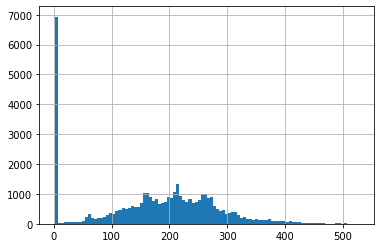

In [109]:
pd.Series([len(str(x).split()) for x in meta['tiabs'].tolist()]).hist(bins = 100)

In [111]:
meta = meta[[((len(str(x).split())>50) and (len(str(x).split())<800)) for x in meta['tiabs']]]
meta.shape

(34185, 22)

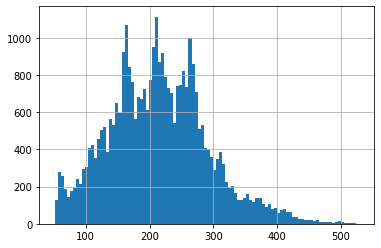

In [113]:
pd.Series([len(str(x).split()) for x in meta['tiabs'].tolist()]).hist(bins = 100)

In [117]:
meta =  meta.rename(columns={'sha':'pid'})

# write-out

In [118]:
meta.to_csv('data/s2_cr_data.csv', encoding='utf-8-sig', index=False)